In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

from torchvision import transforms,datasets
import torchvision.transforms.functional as TF

import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from tqdm import tqdm
import h5py
import seaborn as sns
import os 
import pickle
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Because Kernel must not died.

C:\ProgramData\Anaconda3\envs\Data_Science\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\envs\Data_Science\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
transform=transforms.Compose([transforms.Grayscale(),
                             transforms.Resize((224,224)),
                            transforms.ToTensor(),
                             ])

In [3]:
dataset=datasets.ImageFolder(root="data_classification",transform=transform)
len(dataset.samples)

3064

In [4]:
indices=list(range(3064))

np.random.shuffle(indices)
split = int(np.floor(0.2 * len(dataset)))
train_indices , test_indices = indices[split:], indices[:split]

In [5]:
from torch.utils.data import SubsetRandomSampler
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

In [6]:
trainloader = torch.utils.data.DataLoader(dataset, 6, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(dataset, 1, sampler=test_sampler)

In [7]:
for x,(images,y) in enumerate(trainloader):
    break
y

tensor([1, 1, 0, 0, 0, 1])

In [19]:
model=torchvision.models.densenet121(pretrained=True)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Onur Çaydere/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [20]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [21]:
model.features.conv0=nn.Conv2d(1,64,7,2,3)
model.classifier=nn.Linear(1024,3)

In [22]:
model=model.cuda()

In [23]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0003)
epochs=40

In [24]:
torch.cuda.max_memory_allocated(0)

28246016

In [25]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   27584 KB |   27584 KB |   27584 KB |       0 B  |
|       from large pool |    2048 KB |    2048 KB |    2048 KB |       0 B  |
|       from small pool |   25536 KB |   25536 KB |   25536 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |   27584 KB |   27584 KB |   27584 KB |       0 B  |
|       from large pool |    2048 KB |    2048 KB |    2048 KB |

In [26]:
train_loss=[]
test_loss=[]
train_acc=[]
test_acc=[]

In [27]:
for epoch in range(epochs):
    correct_train=0
    for batch,(x_train,y_train) in enumerate(trainloader):
        x_train=x_train.cuda()
        y_train=y_train.cuda()
        
        optimizer.zero_grad()
        
        out=model(x_train)
        
        loss=criterion(out,y_train)
        
        pred=torch.max(out.data,1)[1]
        
        correct_train=(pred==y_train).sum()
        loss.backward()
        optimizer.step()
        if(batch%500==0):
            print("Epoch {} Batch {} Loss {} ".format(epoch,batch,loss.item()))

    train_loss.append(loss.item())
    train_acc.append(correct_train)
    
    with torch.no_grad():
        test_correct=0
        acc=0
        for batch,(x_test,y_test) in enumerate(testloader):
            x_test=x_test.cuda()
            y_test=y_test.cuda()
            
            pred=model(x_test)
            out=torch.max(pred.data,1)[1]

            test_correct=(out==y_test).sum()
        acc=100*test_correct/float(len(testloader))
        loss=criterion(pred,y_test)
        test_loss.append(loss.item())
        test_acc.append(test_correct)
            


Epoch 0 Batch 0 Loss 1.0515698194503784 
Epoch 1 Batch 0 Loss 0.07138895243406296 
Epoch 2 Batch 0 Loss 0.03276355192065239 
Epoch 3 Batch 0 Loss 0.1921708732843399 
Epoch 4 Batch 0 Loss 0.11002200096845627 
Epoch 5 Batch 0 Loss 0.12138231843709946 
Epoch 6 Batch 0 Loss 0.04303233325481415 
Epoch 7 Batch 0 Loss 0.0169049259275198 
Epoch 8 Batch 0 Loss 0.04257725179195404 
Epoch 9 Batch 0 Loss 0.22821800410747528 
Epoch 10 Batch 0 Loss 0.0090095279738307 
Epoch 11 Batch 0 Loss 0.009467098861932755 
Epoch 12 Batch 0 Loss 0.0055386219173669815 
Epoch 13 Batch 0 Loss 0.009542468003928661 
Epoch 14 Batch 0 Loss 0.05718991532921791 
Epoch 15 Batch 0 Loss 0.0055842529982328415 
Epoch 16 Batch 0 Loss 0.0020912676118314266 
Epoch 17 Batch 0 Loss 0.023625947535037994 
Epoch 18 Batch 0 Loss 0.0030188558157533407 
Epoch 19 Batch 0 Loss 0.13553474843502045 
Epoch 20 Batch 0 Loss 0.0004326915368437767 
Epoch 21 Batch 0 Loss 0.0017685374477878213 
Epoch 22 Batch 0 Loss 0.0005871294415555894 
Epoch 23

In [28]:
torch.save(model.state_dict(),"classification_model.pt")

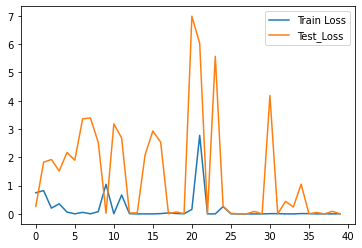

In [29]:
plt.plot(train_loss,label="Train Loss")
plt.plot(test_loss,label="Test_Loss")
plt.legend()

In [93]:
pre_trained_model=torchvision.models.densenet121(pretrained=True)

In [94]:
pre_trained_model.features.conv0=nn.Conv2d(1,64,7,2,3)
pre_trained_model.classifier=nn.Linear(1024,3)

In [95]:
pre_trained_model.load_state_dict(torch.load("classification_model.pt"))
pre_trained_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inp

In [96]:
all_test_loader = torch.utils.data.DataLoader(dataset, 612, sampler=test_sampler)
with torch.no_grad():
    correct=0
    for b,(x_test,y_test) in enumerate(all_test_loader):

        out=pre_trained_model(x_test)
        predict=torch.max(out.data,1)[1]
        correct+=(predict==y_test).sum()
correct.item()/612

0.8839869281045751

In [97]:
from sklearn.metrics import confusion_matrix,classification_report

In [98]:
cm=confusion_matrix(predict.view(-1),y_test.view(-1))

In [99]:
cr=classification_report(predict.view(-1),y_test.view(-1))
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       344
           1       0.54      1.00      0.70        74
           2       0.96      0.97      0.97       194

    accuracy                           0.88       612
   macro avg       0.83      0.93      0.85       612
weighted avg       0.93      0.88      0.89       612



<AxesSubplot:>

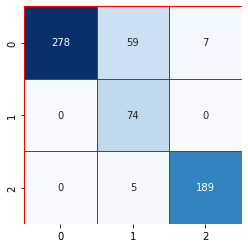

In [100]:
sns.heatmap(cm,square=True, annot=True,cbar=False,cmap=plt.cm.Blues,fmt="d",linewidths=1,linecolor="red")

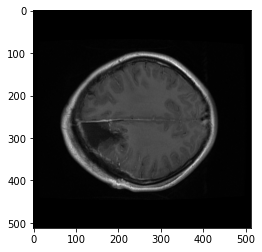

In [79]:
img=Image.open("data_classification/glioma/2048.png")
plt.imshow(img)

trans=transforms.Compose([transforms.Grayscale(),
            transforms.Resize((512, 512))])
img=trans(img)
img=TF.to_tensor(img)
img=img.numpy()
image_tensor=torch.Tensor(img)
image_tensor=image_tensor.view((-1,1,512,512))

In [80]:
classes=["meningioma","glioma","pituitary tumor"]
with torch.no_grad():
    out=pre_trained_model(image_tensor).argmax()
classes[out.item()]


'meningioma'